# Aula prática - Filtros
* Disciplina: Sistemas de comunicação
* Professor: Carmelo José Albanez Bastos Filho

## O que são filtros?
Filtros são componentes que são capazes de remover componentes indesejados ou evidenciar características de um sinal. Em sistemas de comunicação, são normalmente utilizados para *separar componentes de informação* ou *corrigir distorções*, por exemplo.

![Diagrama de blocos de um filtro de linhas transversais](static/image/filtro_transversal.png)

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy import signal

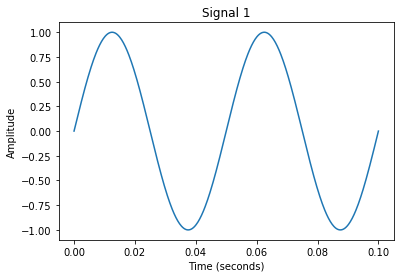

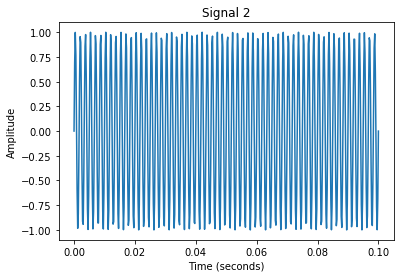

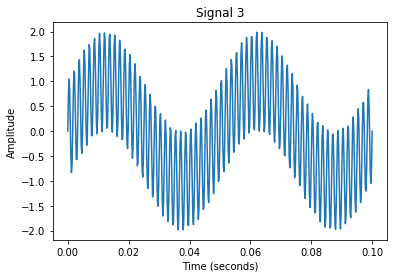

In [2]:
sampling_rate = 5000   # Hz
signal_duration = 0.1    # seconds

sampling_period = 1.0 / sampling_rate   # seconds
signal_domain = np.linspace(0, signal_duration, int(sampling_rate * signal_duration))

f1 = 20     # Hz
f2 = 600     # Hz

s1 = np.sin(2 * np.pi * signal_domain * f1) # A 2Hz sinusoid wave 
s2 = np.sin(2 * np.pi * signal_domain * f2) # A 6Hz sinusoid wave
s3 = s1 + s2   # A compounf of the two waves defined earlier

# Plotting each signal
plt.figure(1)
plt.title('Signal 1')
plt.ylabel('Amplitude')
plt.xlabel('Time (seconds)')
plt.plot(signal_domain, s1)

plt.figure(2)
plt.title('Signal 2')
plt.ylabel('Amplitude')
plt.xlabel('Time (seconds)')
plt.plot(signal_domain, s2)

plt.figure(3)
plt.title('Signal 3')
plt.ylabel('Amplitude')
plt.xlabel('Time (seconds)')
plt.plot(signal_domain, s3)

In [3]:
def plot_filter_response(f):
    w, h = signal.freqz(f)

    fig, ax1 = plt.subplots()
    ax1.set_title('Digital filter frequency response')

    ax1.plot(w, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.grid()
    ax2.axis('tight')
    plt.show()
    
def convolve(x, h):
    xr = [0] * h.shape[0]
    
    def run(signal, regressor):
        y = []
        for sample in signal:
            regressor.insert(0, sample)
            regressor.pop()
            y.append(np.dot(np.array(regressor), h))
            
        return y
    
    y = run(x, xr) + run(np.zeros(h.shape[0] - 1), xr)
    return np.array(y)

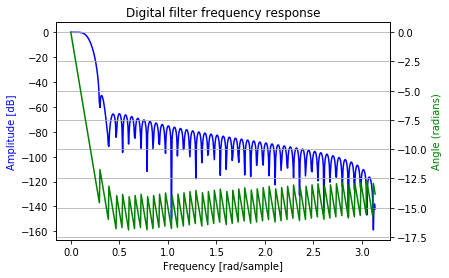

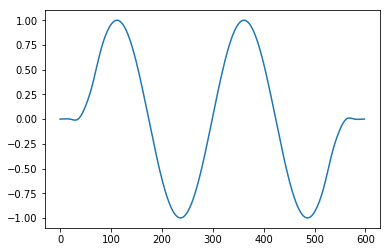

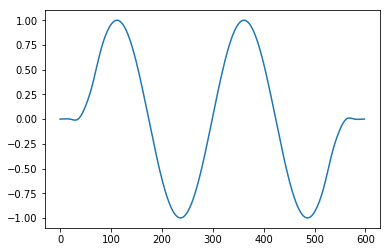

In [5]:
f = signal.firwin(100, 300.0 / sampling_rate)

y = convolve(s3, f)
y1 = signal.convolve(s3, f)
plt.figure(1)
plt.plot(y)

plt.figure(2)
plt.plot(y1)

In [6]:
def create_noisy_wavfile(source, target):
    # Read info from source file
    # audio_sampling will be the sampling frequency used to record the file
    # stereo_data is a numpy ndarray with shape (num_samples, num_channels)
    audio_sampling, stereo_data = wavfile.read(source)
    print(audio_sampling, stereo_data.shape, stereo_data[0:10,:])
    
    max_value = np.abs(stereo_data).max()
    num_samples = stereo_data.shape[0]
    num_channels = stereo_data.shape[1]
    audio_duration = num_samples / audio_sampling   # seconds
    
    # Create a 8000Hz sinusoid wave to act as noise
    # Be sure to use the same sampling rate used in the audio file
    # Also, use the number of samples to produce a wave of same duration
    noise_frequency = 8000
    noise_domain = np.linspace(0, audio_duration, num_samples)
    noise = np.sin(2 * np.pi * noise_domain * noise_frequency)
    plt.plot(noise_domain, stereo_data[:,0])
    
    # Normalize data to [-1, 1] range, so it will be easier to write the file after processing it
    # Then, add noise
    normalized_stereo_data = stereo_data / max_value
    channels = []
    for channel in range(num_channels):
        channels.append(0.8 * normalized_stereo_data[:, channel] + 0.2 * noise)
    
    # Stack channels together and denormalize it to write to the target file
    normalized_data = np.stack(channels, axis=1)
    data = (normalized_data * max_value).astype(stereo_data.dtype)
    wavfile.write(target, audio_sampling, data)

44100 (379261, 2) [[ 0  0]
 [ 1  0]
 [ 0  0]
 [-1  0]
 [ 0  0]
 [ 0  0]
 [-1  0]
 [ 0  0]
 [ 1  0]
 [ 0  0]]


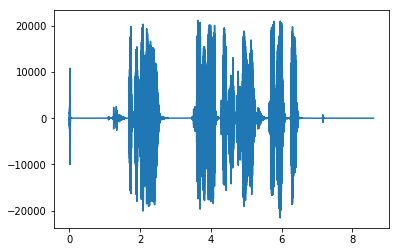

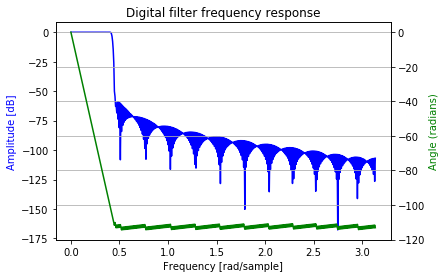

In [7]:
create_noisy_wavfile('static/audio/mom.wav', 'static/audio/noisy_mom.wav')

audio_sampling, stereo_data = wavfile.read('static/audio/noisy_mom.wav')
num_channels = stereo_data.shape[1]
max_value = np.abs(stereo_data).max()
f = signal.firwin(500, 6000.0 / audio_sampling)

w, h = signal.freqz(f)

fig, ax1 = plt.subplots()
ax1.set_title('Digital filter frequency response')

ax1.plot(w, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [rad/sample]')

ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(w, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.grid()
ax2.axis('tight')
plt.show()

normalized_stereo_data = stereo_data / max_value
left_data = normalized_stereo_data[:,0]
right_data = normalized_stereo_data[:,1]
#filtered_left_data = convolve(left_data, f)
#filtered_right_data = convolve(right_data, f)
filtered_left_data = left_data
filtered_right_data = right_data

normalized_data = np.stack((filtered_left_data, filtered_right_data), axis=1)
data = (normalized_data * max_value).astype(stereo_data.dtype)
wavfile.write('static/audio/filtered_mom.wav', audio_sampling, data)